# COBAR Project 

Authors: Célia Benquet, Artur Jesslen & Léa Schmidt

## Import library

In [1]:
import pickle
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd 
import seaborn as sns
from scipy import signal

## Class experiment

In [11]:
class Experiment:
    def __init__(self, mov_av = 30):
        self.load_data()
        self.stage_name = ['off0', 'on0', 'off1', 'on1','off2', 'on2', 'off3']
        self.dt = 1. / 80
        self.pixel_to_mm = 32. / 832
        self.width_mov_av_claw = mov_av
        self.width_mov_av_speed = mov_av
        
        self.include_stage_and_update_data()
        
        self.replicates_MDN_sorted = self.prepare_data(self.data_MDN)
        self.replicates_SS_sorted = self.prepare_data(self.data_SS)
        self.replicates_PR_sorted = self.prepare_data(self.data_PR)
        
        self.flies = []
        
    def add_fly(self, fly):
        self.flies.append(fly)
        
    def include_stage_and_update_data(self, off0 = True, on0  = True, off1  = True, on1  = True, off2  = True, on2  = True, off3  = True):
        self.stage_activate = [off0, on0, off1, on1, off2, on2, off3]
        
        self.replicates_MDN_sorted = self.prepare_data(self.data_MDN)
        self.replicates_SS_sorted = self.prepare_data(self.data_SS)
        self.replicates_PR_sorted = self.prepare_data(self.data_PR)
    
    def load_data(self):
        path_MDN = 'data/MDN/U3_f'
        path_SS = 'data/SS01540/U3_f'
        path_PR = 'data/PR/U3_f'
        with open(path_MDN + '/MDN_U3_f_trackingData.pkl', 'rb') as f: 
            self.data_MDN = pickle.load(f).reset_index()
        with open(path_SS + '/SS01540_U3_f_trackingData.pkl', 'rb') as f: 
            self.data_SS = pickle.load(f).reset_index()
        with open(path_PR + '/PR_U3_f_trackingData.pkl', 'rb') as f: 
            self.data_PR = pickle.load(f).reset_index()
            
    def prepare_data(self, data_raw):
        replicates_raw_sorted = []
        replicates = [data_raw[data_raw['replicate'] == i] for i in range(1, 13)]
        for replicate in replicates:
            stage_sorted = pd.DataFrame([])
            for stage, stage_is_included in zip(self.stage_name, self.stage_activate):
                if stage_is_included:
                    stage_sorted = stage_sorted.append(replicate[replicate['exp_stage'] == stage], ignore_index = True)
            stage_sorted = stage_sorted.reset_index()
            replicates_raw_sorted.append(stage_sorted)
        return replicates_raw_sorted

    def plot_positions(self, fly = None, MDN = False, SS = False, PR = False):
        if fly is None:
            for fly_ in self.flies:
                fly_.plot_positions(MDN, SS, PR)
        else:
            for fly_nb in fly:
                self.flies[fly_nb].plot_positions(MDN, SS, PR)
                
    def compute_pos_and_speed(self, moving_average = False):

        for fly_ in self.flies:
            fly_.compute_pos_and_speed(self, moving_average)
        
        self.pos = fly_.positions_MDN
        
            
    def compute_claws(self, moving_average = False):
        for fly_ in self.flies:
            fly_.compute_claws(self, moving_average)
            
    def plot_speeds(self, fly = None, MDN = False, SS = False, PR = False, display_background = True):
        if fly is None:
            for fly_ in self.flies:
                fly_.plot_speeds(MDN, SS, PR, display_background)
        else:
            for fly_nb in fly:
                self.flies[fly_nb].plot_speeds(MDN, SS, PR, display_background)
                
    def plot_claws(self, fly = None, MDN = False, SS = False, PR = False, display_background = False):
        if fly is None:
            for fly_ in self.flies:
                fly_.plot_claws(MDN, SS, PR, display_background)
        else:
            for fly_nb in fly:
                self.flies[fly_nb].plot_claws(MDN, SS, PR, display_background)
        

## Class Fly

In [12]:
class Fly:
    def __init__(self, exp, id_):
        self.id = id_
        
        self.replicates_nb_MDN = exp.data_MDN[exp.data_MDN['fly'] == id_]['replicate'].unique()
        self.replicates_nb_SS = exp.data_SS[exp.data_SS['fly'] == id_]['replicate'].unique()
        self.replicates_nb_PR = exp.data_PR[exp.data_PR['fly'] == id_]['replicate'].unique()
        
        self.replicates_MDN = [exp.replicates_MDN_sorted[i-1] for i in self.replicates_nb_MDN]
        self.replicates_SS = [exp.replicates_SS_sorted[i-1] for i in self.replicates_nb_SS]
        self.replicates_PR = [exp.replicates_PR_sorted[i-1] for i in self.replicates_nb_PR]
        
        self.compute_pos_and_speed(exp)
        
        self.claws_name = ['LFclaw', 'LMclaw', 'LHclaw', 'RFclaw', 'RMclaw', 'RHclaw']
        #self.claws_name = ['LFtibiaTarsus', 'LMtibiaTarsus', 'LHtibiaTarsus', 'RFtibiaTarsus', 'RMtibiaTarsus', 'RHtibiaTarsus']
        self.compute_claws(exp)
        
    def compute_pos_and_speed(self, exp, moving_average = False):
        self.positions_MDN = self.compute_position(self.replicates_MDN)
        self.positions_SS = self.compute_position(self.replicates_SS)
        self.positions_PR = self.compute_position(self.replicates_PR)
        
        self.speeds_MDN = self.compute_speed(self.replicates_MDN, exp, moving_average)
        self.speeds_SS = self.compute_speed(self.replicates_SS, exp, moving_average)
        self.speeds_PR = self.compute_speed(self.replicates_PR, exp, moving_average)
    
    def compute_claws(self, exp, moving_average = False):
        self.positions_claws_MDN = self.compute_position_claws(self.replicates_MDN, exp, moving_average)
        self.positions_claws_SS = self.compute_position_claws(self.replicates_SS, exp, moving_average)
        self.positions_claws_PR = self.compute_position_claws(self.replicates_PR, exp, moving_average)
        
    def compute_position(self, replicates):
        return [[replicate['center','pos' + ax] for ax in ['x', 'y']] for replicate in replicates]
    
    def compute_speed(self, replicates, exp, moving_average = False):
        self.width_mov_av_speed = exp.width_mov_av_speed
        self.moving_average_speed = moving_average
        positions = [[self.sub_to_itself(replicate['center','pos' + ax]) for ax in ['x', 'y']] for replicate in replicates]
        fly_orientations = [replicate['center','orientation'] for replicate in replicates]
        
        speed_magnitudes = [np.sqrt(pos[0]**2 + pos[1]**2) * exp.pixel_to_mm / exp.dt for pos in positions]
        speed_angles = [(np.arctan2(pos[0], -pos[1]) * 180 / np.pi + 360) % 360  for pos in positions]
        angles = [(speed_angle - fly_orientation + 180) % 360 - 180 for speed_angle, fly_orientation in zip(speed_angles, fly_orientations)]

        if self.moving_average_speed:
            ma_filter = np.ones(self.width_mov_av_speed) / self.width_mov_av_speed
            speed_magnitudes = [np.convolve(speed_magnitude, ma_filter, 'same') for speed_magnitude in speed_magnitudes]
            projection_ratio = [np.convolve(np.cos(angle * np.pi/180), ma_filter, 'same') for angle in angles]
            return [ratio * speed_magnitude for ratio, speed_magnitude in zip(projection_ratio, speed_magnitudes)]
        
        return [np.cos(angle * np.pi/180) * speed_magnitude for angle, speed_magnitude in zip(angles, speed_magnitudes)]

    
    def compute_position_claws(self, replicates, exp, moving_average = False):
        self.width_mov_av_claw = exp.width_mov_av_claw
        self.moving_average_claw = moving_average
        if moving_average:
            ma_filter = np.ones(self.width_mov_av_claw) / self.width_mov_av_claw
            return [[[np.convolve(replicate[claws, ax], ma_filter, 'same') for ax in ['x', 'y']] for claws in self.claws_name] for replicate in replicates]
        return [[[replicate[claws, ax] for ax in ['x', 'y']] for claws in self.claws_name] for replicate in replicates]
    
    
    def sub_to_itself(self, data_frame):
        return data_frame.subtract(data_frame.copy().shift())
    
    def plot_positions(self, MDN = False, SS = False, PR = False):
        if MDN:
            plt.figure(figsize=(40, 10))
            plt.suptitle('Position (MDN data)', fontsize=32)
            for i, replicate_nb in zip(range(len(self.replicates_nb_MDN)), self.replicates_nb_MDN):
                plt.subplot(1, len(self.replicates_nb_MDN), i + 1) 
                plt.plot(self.positions_MDN[i][0], self.positions_MDN[i][1], color= 'r')
                plt.xlim(0, 832)
                plt.ylim(0, 832)
                plt.gca().invert_yaxis()
                plt.xlabel('X-axis')
                plt.ylabel('Y-axis')
                plt.title('Fly {}: replicate {}'.format(self.id,  replicate_nb), fontsize=16)
            plt.show()
        if SS:
            plt.figure(figsize=(40, 10))
            plt.suptitle('Position (SS data)', fontsize=32)
            for i, replicate_nb in zip(range(len(self.replicates_nb_SS)), self.replicates_nb_SS):
                plt.subplot(1, len(self.replicates_nb_SS), i + 1) 
                plt.plot(self.positions_SS[i][0], self.positions_SS[i][1], color= 'g')
                plt.xlim(0, 832)
                plt.ylim(0, 832)
                plt.gca().invert_yaxis()
                plt.xlabel('X-axis')
                plt.ylabel('Y-axis')
                plt.title('Fly {}: replicate {}'.format(self.id,  replicate_nb), fontsize=16)
            plt.show()
        if PR:
            plt.figure(figsize=(40, 10))
            plt.suptitle('Position (PR data)', fontsize=32)
            for i, replicate_nb in zip(range(len(self.replicates_nb_PR)), self.replicates_nb_PR):
                plt.subplot(1, len(self.replicates_nb_PR), i + 1) 
                plt.plot(self.positions_PR[i][0], self.positions_PR[i][1], color= 'b')
                plt.xlim(0, 832)
                plt.ylim(0, 832)
                plt.gca().invert_yaxis()
                plt.xlabel('X-axis')
                plt.ylabel('Y-axis')
                plt.title('Fly {}: replicate {}'.format(self.id,  replicate_nb), fontsize=16)
            plt.show()
            
    def plot_speeds(self, MDN = False, SS = False, PR = False, display_background = False):
        if MDN:
            plt.figure(figsize=(40, 10))
            plt.suptitle('Forward/Backward Speed (MDN data)', fontsize=32)
            for i, replicate_nb in zip(range(len(self.replicates_nb_MDN)), self.replicates_nb_MDN):
                plt.subplot(1, len(self.replicates_nb_MDN), i + 1) 
                plt.plot(range(self.speeds_MDN[i].shape[0]), self.speeds_MDN[i], color= 'r')
                plt.xlabel('Frame number')
                plt.ylabel('Speed (Fly longitudinal axis)')
                plt.title('Fly {}: replicate {} - moving average width : {}'.format(self.id,  replicate_nb, self.width_mov_av_speed if self.moving_average_speed else 'None'), fontsize=16)
                if display_background:
                    self.color_background(plt.gca(), self.replicates_MDN[i]['exp_stage'])
                    plt.legend()
            plt.show()
        if SS:
            plt.figure(figsize=(40, 10))
            plt.suptitle('Forward/Backward Speed (SS data)', fontsize=32)
            for i, replicate_nb in zip(range(len(self.replicates_nb_SS)), self.replicates_nb_SS):
                plt.subplot(1, len(self.replicates_nb_SS), i + 1) 
                plt.plot(range(self.speeds_SS[i].shape[0]), self.speeds_SS[i], color= 'g')
                plt.xlabel('Frame number')
                plt.ylabel('Speed (Fly longitudinal axis)')
                plt.title('Fly {}: replicate {} - moving average width : {}'.format(self.id,  replicate_nb, self.width_mov_av_speed if self.moving_average_speed else 'None'), fontsize=16)
                if display_background:
                    self.color_background(plt.gca(), self.replicates_SS[i]['exp_stage'])
                    plt.legend()
            plt.show()
        if PR:
            plt.figure(figsize=(40, 10))
            plt.suptitle('Forward/Backward Speed (PR data)', fontsize=32)
            for i, replicate_nb in zip(range(len(self.replicates_nb_PR)), self.replicates_nb_PR):
                plt.subplot(1, len(self.replicates_nb_PR), i + 1) 
                plt.plot(range(self.speeds_PR[i].shape[0]), self.speeds_PR[i], color= 'b')
                plt.xlabel('Frame number')
                plt.ylabel('Speed (Fly longitudinal axis)')
                plt.title('Fly {}: replicate {} - moving average width : {}'.format(self.id,  replicate_nb, self.width_mov_av_speed if self.moving_average_speed else 'None'), fontsize=16)
                if display_background:
                    self.color_background(plt.gca(), self.replicates_PR[i]['exp_stage'])
                    plt.legend()
            plt.show()
            
    def plot_claws(self, MDN = False, SS = False, PR = False, display_background = False):
        if MDN:
            plt.figure(figsize=(40, 20))
            plt.suptitle('Claws position (MDN data)', fontsize=32)
            for i, replicate_nb in zip(range(len(self.replicates_nb_MDN)), self.replicates_nb_MDN):
                plt.subplot(2, len(self.replicates_nb_MDN), i + 1) 
                for j in range(len(self.claws_name)):
                    plt.plot(range(self.positions_claws_MDN[i][j][1].shape[0]), self.positions_claws_MDN[i][j][1], label=self.claws_name[j])
                plt.gca().invert_yaxis()
                plt.xlabel('Frame number')
                plt.ylabel('Claws position (y axis)')
                plt.title('Fly {}: replicate {} - moving average width : {} (Y-axis)'.format(self.id,  replicate_nb, self.width_mov_av_claw if self.moving_average_claw else 'None'), fontsize=16)
                if display_background:
                    self.color_background(plt.gca(), self.replicates_MDN[i]['exp_stage'])
                plt.legend()
                
                plt.subplot(2, len(self.replicates_nb_MDN), i + len(self.replicates_nb_MDN) + 1) 
                for j in range(len(self.claws_name)):
                    plt.plot(self.positions_claws_MDN[i][j][0], range(self.positions_claws_MDN[i][j][0].shape[0]), label=self.claws_name[j])
                plt.gca().invert_yaxis()
                plt.xlabel('Claws position (x axis)')
                plt.ylabel('Frame number')
                plt.title('Fly {}: replicate {} - moving average width : {} (X-axis)'.format(self.id,  replicate_nb, self.width_mov_av_claw if self.moving_average_claw else 'None'), fontsize=16)
                if display_background:
                    self.color_background(plt.gca(), self.replicates_MDN[i]['exp_stage'], False)
                plt.legend()
            plt.show()
        if SS:
            plt.figure(figsize=(40, 20))
            plt.suptitle('Claws position (SS data)', fontsize=32)
            for i, replicate_nb in zip(range(len(self.replicates_nb_SS)), self.replicates_nb_SS):
                plt.subplot(2, len(self.replicates_nb_SS), i + 1) 
                for j in range(len(self.claws_name)):
                    plt.plot(range(self.positions_claws_SS[i][j][1].shape[0]), self.positions_claws_SS[i][j][1], label=self.claws_name[j])
                plt.gca().invert_yaxis()
                plt.xlabel('Frame number')
                plt.ylabel('Claws position (y axis)')
                plt.title('Fly {}: replicate {} - moving average width : {} (Y-axis)'.format(self.id,  replicate_nb, self.width_mov_av_claw if self.moving_average_claw else 'None'), fontsize=16)
                if display_background:
                    self.color_background(plt.gca(), self.replicates_SS[i]['exp_stage'])
                plt.legend()
                
                plt.subplot(2, len(self.replicates_nb_SS), i + len(self.replicates_nb_SS) + 1) 
                for j in range(len(self.claws_name)):
                    plt.plot(self.positions_claws_SS[i][j][0], range(self.positions_claws_SS[i][j][0].shape[0]), label=self.claws_name[j])
                plt.gca().invert_yaxis()
                plt.xlabel('Claws position (x axis)')
                plt.ylabel('Frame number')
                plt.title('Fly {}: replicate {} - moving average width : {} (X-axis)'.format(self.id,  replicate_nb, self.width_mov_av_claw if self.moving_average_claw else 'None'), fontsize=16)
                if display_background:
                    self.color_background(plt.gca(), self.replicates_SS[i]['exp_stage'], False)
                plt.legend()
            plt.show()
        if PR:
            plt.figure(figsize=(40, 20))
            plt.suptitle('Claws position (PR data)', fontsize=32)
            for i, replicate_nb in zip(range(len(self.replicates_nb_PR)), self.replicates_nb_PR):
                plt.subplot(2, len(self.replicates_nb_PR), i + 1) 
                for j in range(len(self.claws_name)):
                    plt.plot(range(self.positions_claws_PR[i][j][1].shape[0]), self.positions_claws_PR[i][j][1], label=self.claws_name[j])
                plt.gca().invert_yaxis()
                plt.xlabel('Frame number')
                plt.ylabel('Claws position (y axis)')
                plt.title('Fly {}: replicate {} - moving average width : {} (Y-axis)'.format(self.id,  replicate_nb, self.width_mov_av_claw if self.moving_average_claw else 'None'), fontsize=16)
                plt.legend(self.claws_name)
                if display_background:
                    self.color_background(plt.gca(), self.replicates_PR[i]['exp_stage'])
                plt.legend()
                
                plt.subplot(2, len(self.replicates_nb_PR), i + len(self.replicates_nb_PR) + 1) 
                for j in range(len(self.claws_name)):
                    plt.plot(self.positions_claws_PR[i][j][0], range(self.positions_claws_PR[i][j][0].shape[0]), label=self.claws_name[j])
                plt.gca().invert_yaxis()
                plt.xlabel('Claws position (x axis)')
                plt.ylabel('Frame number')
                plt.title('Fly {}: replicate {} - moving average width : {} (X-axis)'.format(self.id,  replicate_nb, self.width_mov_av_claw if self.moving_average_claw else 'None'), fontsize=16)
                if display_background:
                    self.color_background(plt.gca(), self.replicates_PR[i]['exp_stage'], False)
                plt.legend()
            plt.show()
            
    def color_background(self, ax, stage, vertical = True):
        label_on = 0
        label_off = 0
        bornes = [[stage[stage == label].index[id_] for id_ in [0,-1]] for label in stage.unique()]
        
        for born, stage_name in zip(bornes, stage.unique()):
            if stage_name.startswith('on'):
                if vertical:
                    ax.axvspan(born[0], born[1], facecolor='g', alpha=0.2, label =  "_"*label_on + "Light on")
                else:
                    ax.axhspan(born[0], born[1], facecolor='g', alpha=0.2, label =  "_"*label_on + "Light on")
                label_on += 1
            else:
                if vertical:
                    ax.axvspan(born[0], born[1], facecolor='r', alpha=0.2, label =  "_"*label_off + "Light off")
                else:
                    ax.axhspan(born[0], born[1], facecolor='r', alpha=0.2, label =  "_"*label_off + "Light off")
                label_off += 1

## Data analysis

In [13]:
# Create experiment and load data 
exp = Experiment(mov_av = 30)

In [14]:
# Include only stage with true value and update data
exp.include_stage_and_update_data(off0 = True, on0 = True, \
                                  off1 = True, on1 = True, \
                                  off2 = False, on2 = False, \
                                  off3 = False)

In [15]:
# Create differents flies with given id
exp.add_fly(Fly(exp, id_ = 0))
exp.add_fly(Fly(exp, id_ = 1))
exp.add_fly(Fly(exp, id_ = 2))

In [16]:
#exp.replicates_MDN_sorted[0].head()


## 2. Question 1a

## 2. Question 1b

the forward / backward speed over time

In [17]:
moving_average = True
exp.width_mov_av_speed = 100
display_background = True 

In [18]:
exp.compute_pos_and_speed(moving_average = moving_average)

In [45]:
positions = np.array([[], []])
for pos in exp.pos:
    print(pos.head())
    np.append(positions[0], pos[0].to_numpy())
    np.append(positions[1], pos[1].to_numpy())
    print(positions.shape)
print(positions)

# HERE!!!!

AttributeError: 'list' object has no attribute 'head'

#### i. MDN data

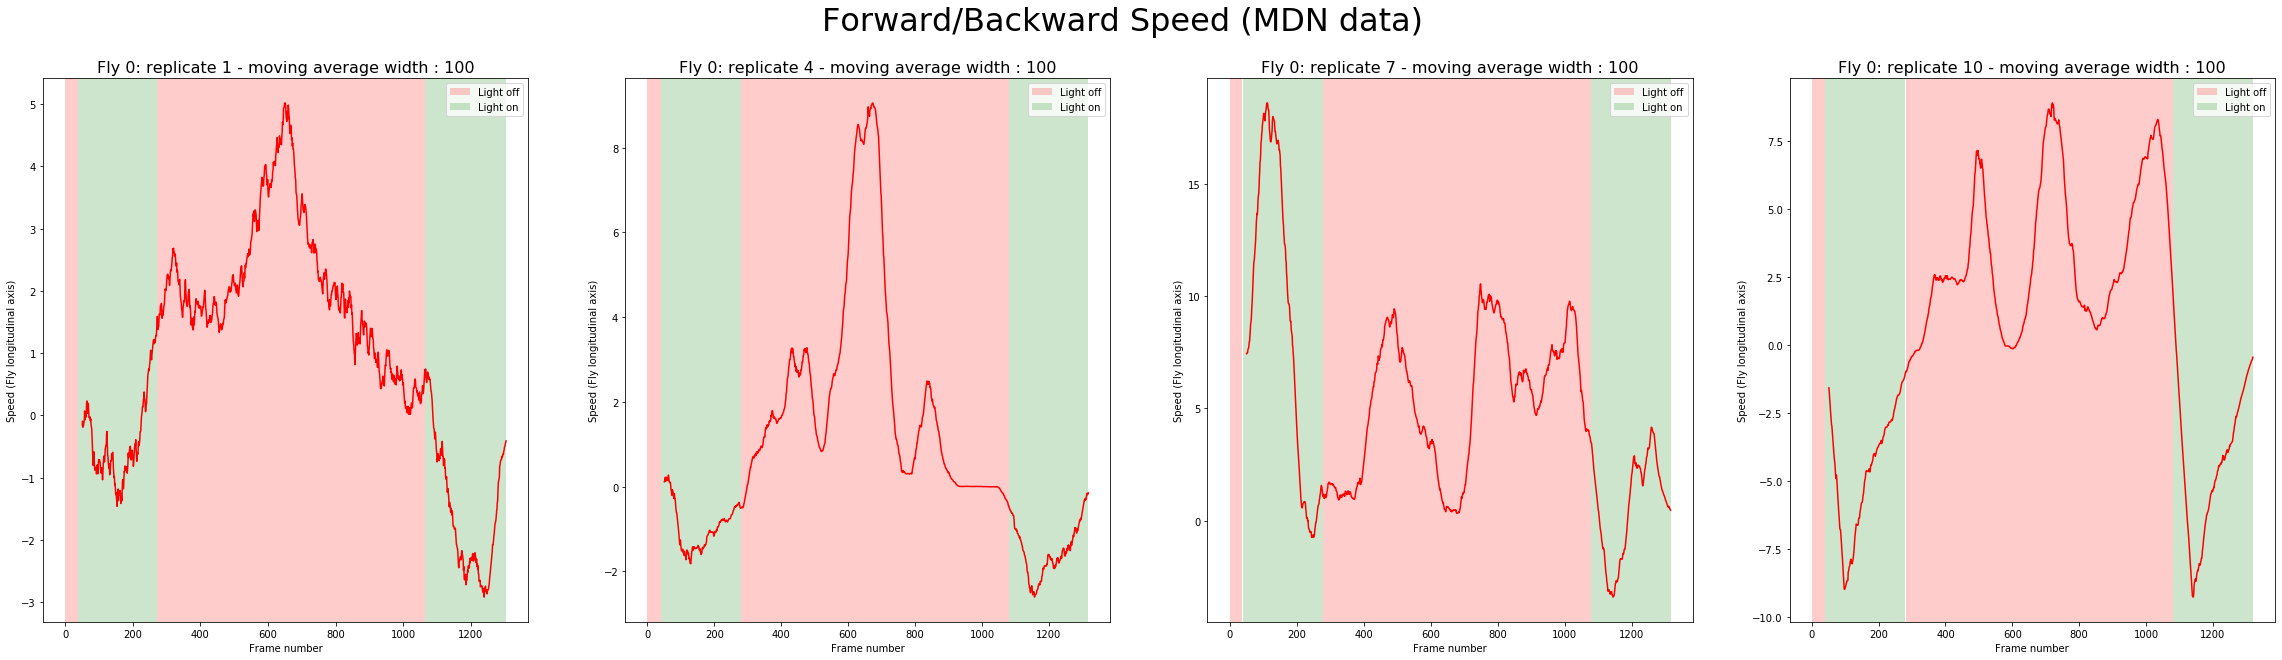

In [13]:
exp.plot_speeds(fly = [0], MDN = True, display_background = display_background)

#### ii. SS data

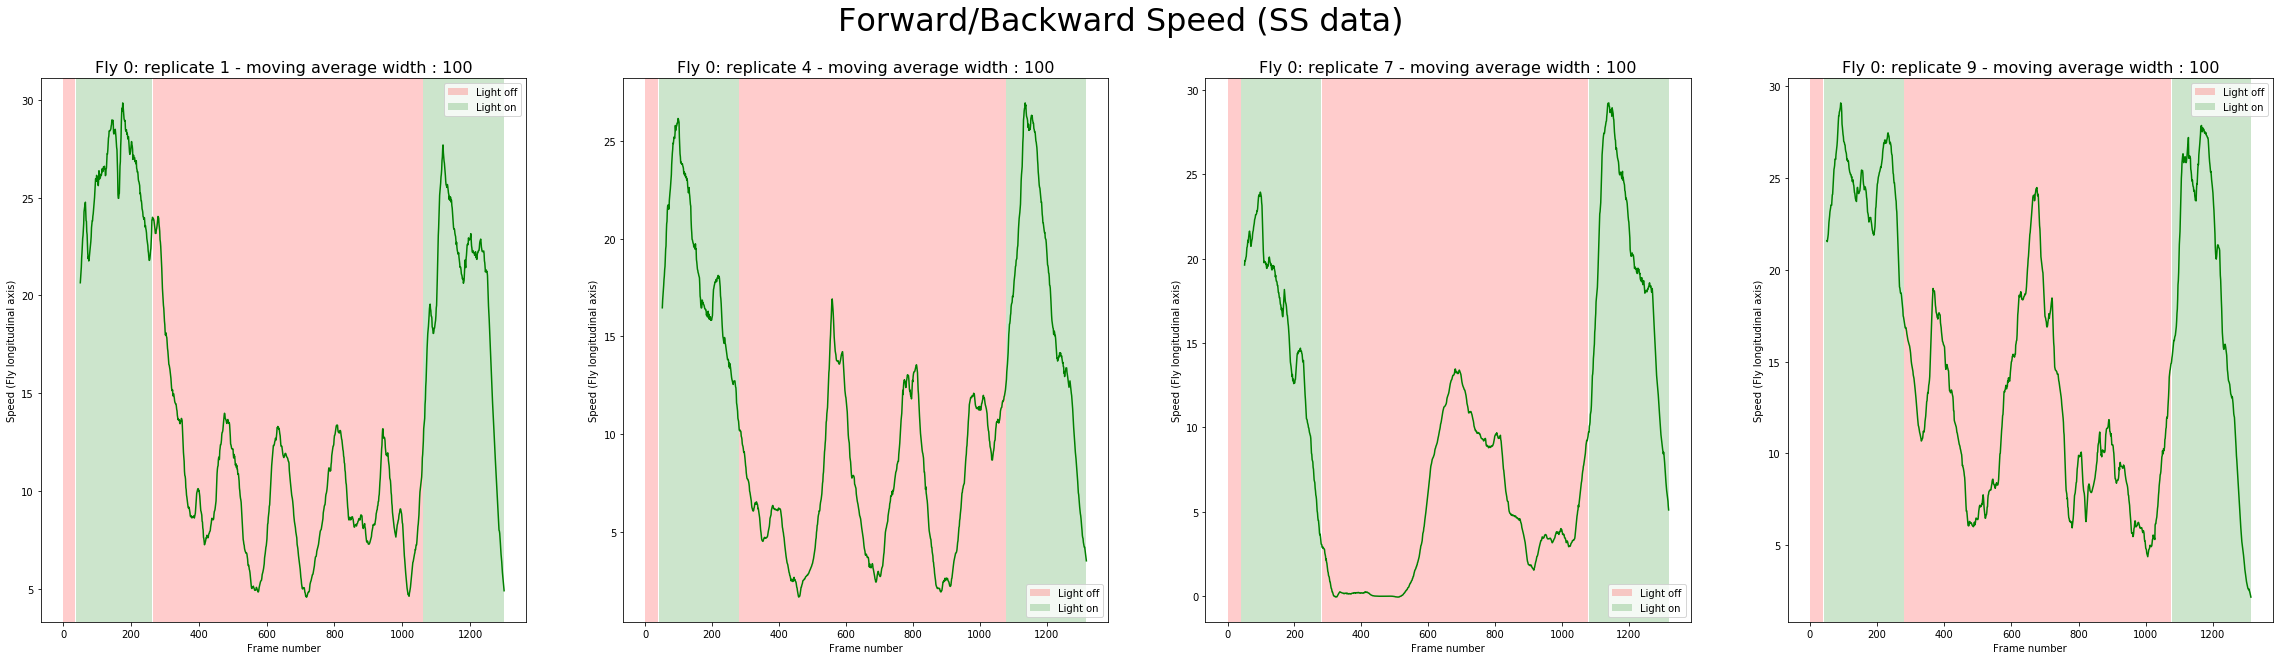

In [14]:
exp.plot_speeds(fly = [0], SS = True, display_background = display_background)

#### iii. PR data

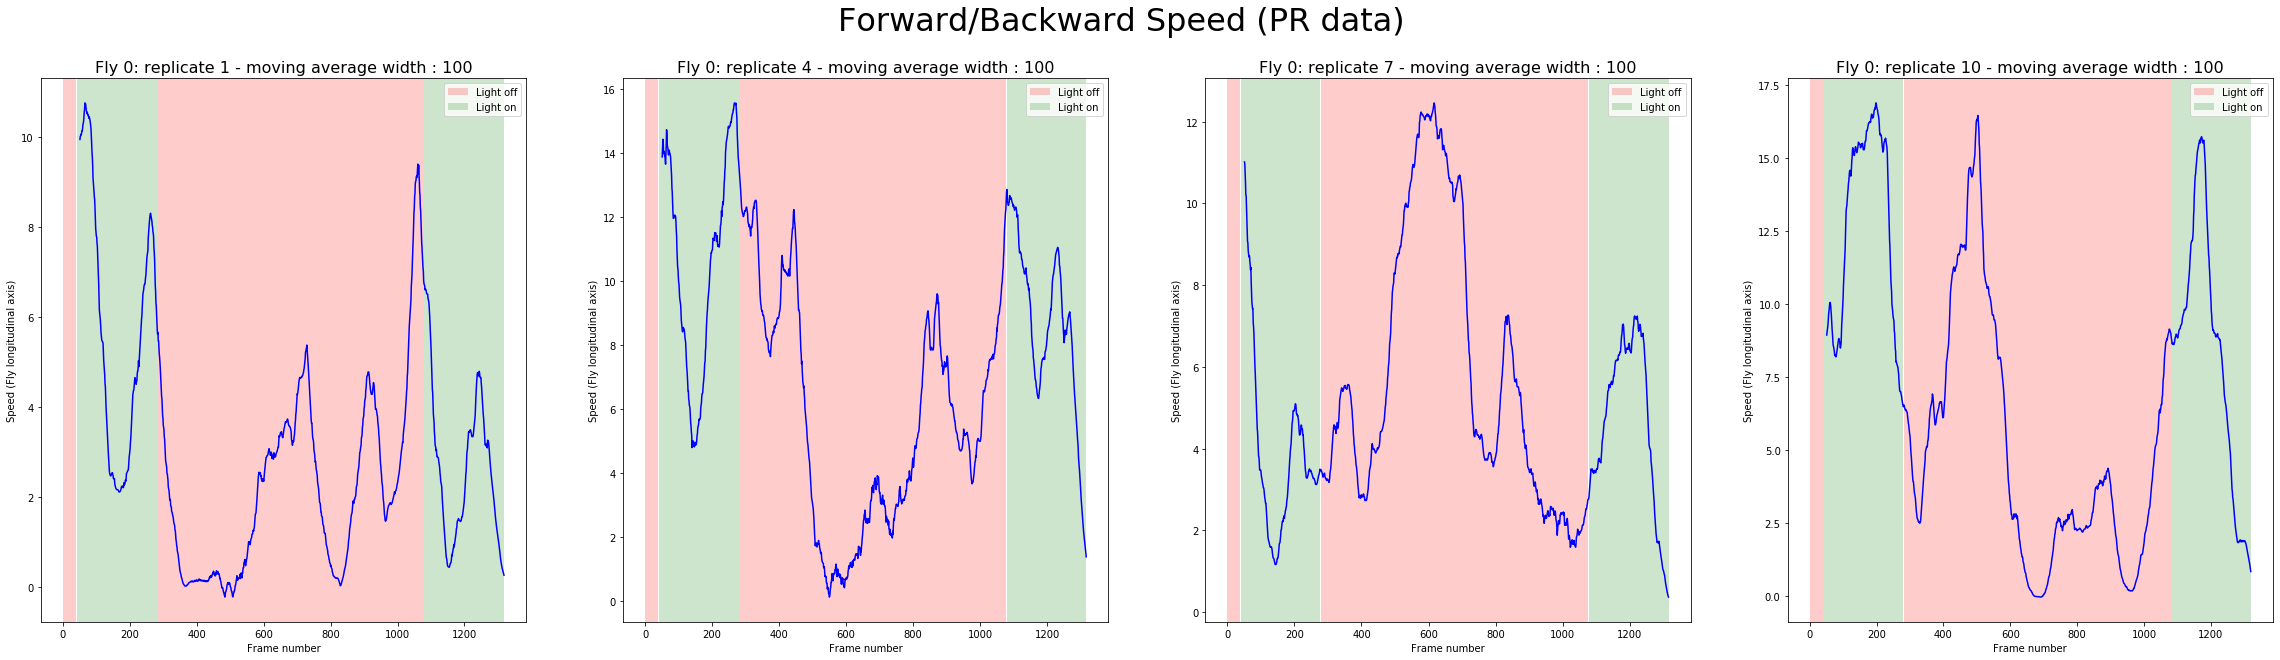

In [15]:
exp.plot_speeds(fly = [0], PR = True, display_background = display_background)

## Question 2.a

In [ ]:
moving_average = True
exp.width_mov_av_claw = 20
display_background = True

In [ ]:
exp.compute_claws(moving_average = moving_average)

In [ ]:
exp.plot_claws(fly = [0], MDN = True, display_background = display_background)

In [ ]:
exp.plot_claws(fly = [0], SS = True, display_background = display_background)

In [ ]:
exp.plot_claws(fly = [0], PR = True, display_background = display_background)

## Clustering 

In [ ]:
exp.data_MDN.head()

In [ ]:
data_clustering_MDN = exp.data_MDN[['LFclaw', 'LMclaw', 'LHclaw', 'RFclaw', 'RMclaw', 'RHclaw']]